# Bitcoin

# 1. Dual Simple Moving Average Crossover Strategy

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [69]:
raw=pd.read_csv("https://raw.githubusercontent.com/towardsuffering/csvs/master/BTC_Prices.csv", index_col=0, parse_dates=True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2014-11-03 to 2021-09-20
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           2514 non-null   float64
 1   24h Open (USD)  2514 non-null   float64
 2   24h High (USD)  2514 non-null   float64
 3   24h Low (USD)   2514 non-null   float64
dtypes: float64(4)
memory usage: 98.2 KB


In [70]:
price = 'Close'

data = (
    pd.DataFrame(raw[price])
    .dropna()
)

data.head()

,Close
Date,
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500
2014-11-07,346.77500


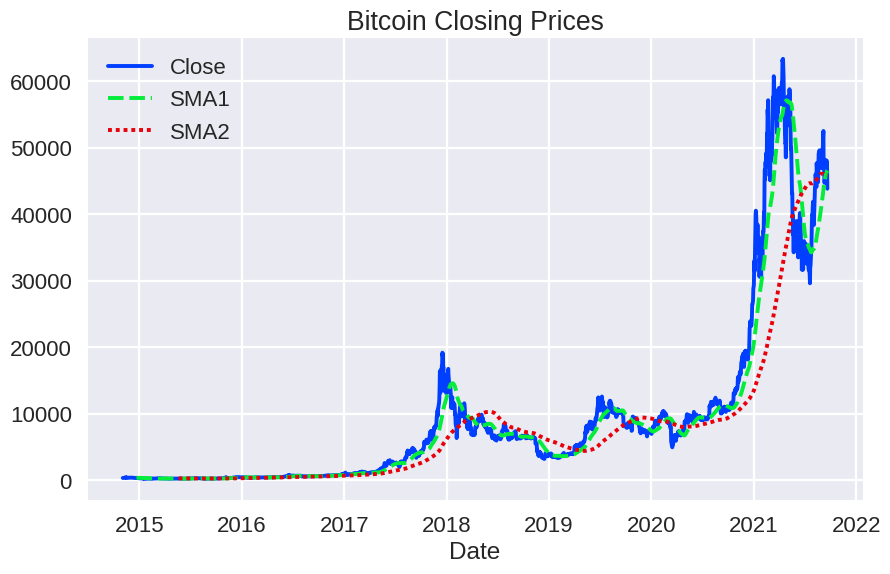

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

SMA1 = 50
SMA2 = 200

data['SMA1'] = data[price].rolling(SMA1).mean()
data['SMA2'] = data[price].rolling(SMA2).mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=data)
plt.title('Bitcoin Closing Prices')
plt.show()


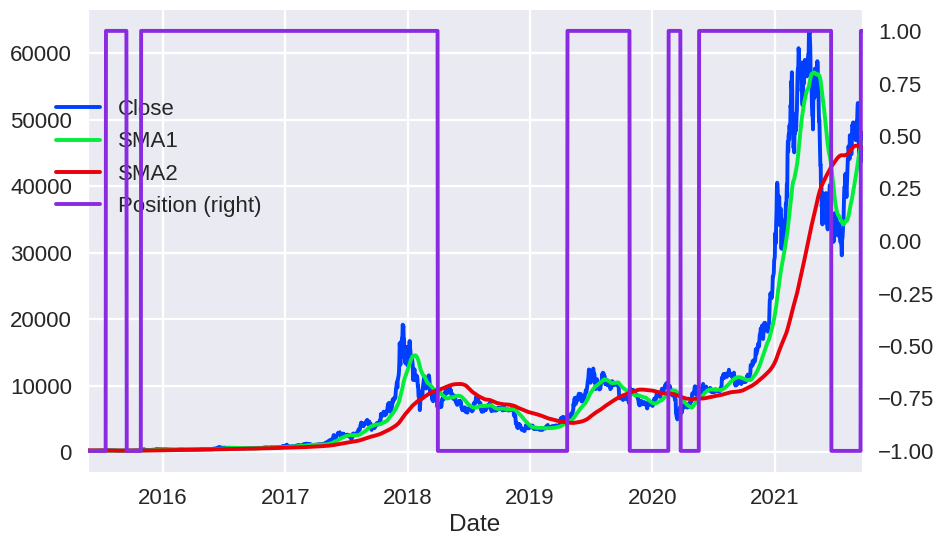

In [72]:
data.dropna(inplace=True)

data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

data.tail()

ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

In [73]:
data['Returns'] = np.log(data[price] / data[price].shift(1))

data['Strategy'] = data['Position'].shift(1) * data['Returns']

data.round(4).head()

data.dropna(inplace=True)

np.exp(data[['Returns', 'Strategy']].sum())

data[['Returns', 'Strategy']].std() * 252 ** 0.5


Returns     0.629134
Strategy    0.629747
dtype: float64

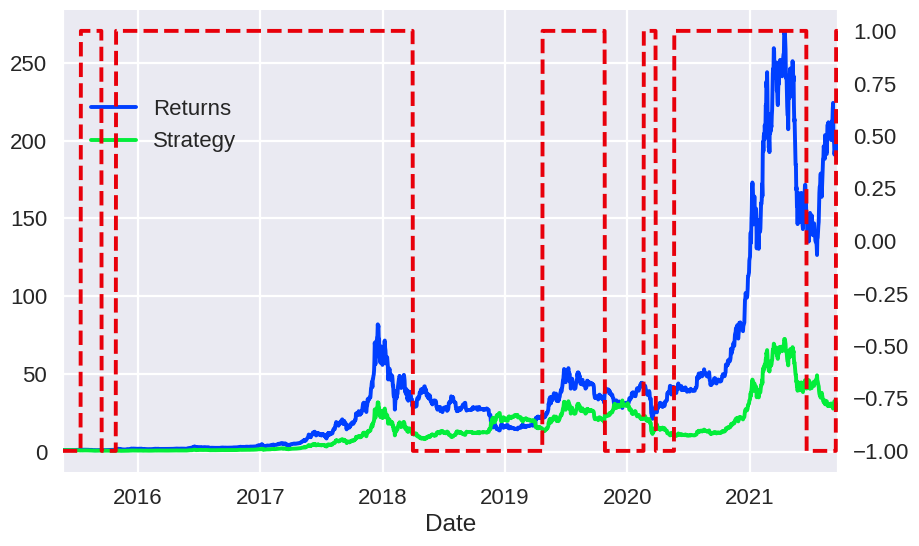

In [74]:
ax = data[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

In [75]:
from itertools import product

sma1 = range(20, 61, 4)
sma2 = range(180, 281, 10)

results = pd.DataFrame()
dfs = []

for SMA1, SMA2 in product(sma1, sma2):
    data = pd.DataFrame(raw[price])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[price] / data[price].shift(1))
    data['SMA1'] = data[price].rolling(SMA1).mean()
    data['SMA2'] = data[price].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())

    dfs.append(pd.DataFrame({
        'SMA1': SMA1, 'SMA2': SMA2,
        'MARKET': perf['Returns'],
        'STRATEGY': perf['Strategy'],
        'OUT': perf['Strategy'] - perf['Returns']
    }, index=[0]))

results = pd.concat(dfs, ignore_index=True)

In [76]:
results.info()
results.sort_values('OUT', ascending=False).head(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      121 non-null    int64  
 1   SMA2      121 non-null    int64  
 2   MARKET    121 non-null    float64
 3   STRATEGY  121 non-null    float64
 4   OUT       121 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


,SMA1,SMA2,MARKET,STRATEGY,OUT
9,20,270,151.866586,37.886295,-113.980291
119,60,270,151.866586,34.531375,-117.335212
18,24,250,162.790480,41.959669,-120.830812
118,60,260,159.802378,37.600545,-122.201833
111,60,190,183.085028,60.828697,-122.256331
22,28,180,185.189770,60.772164,-124.417606
21,24,280,167.453058,41.110763,-126.342295


# 2. Random Walk Hypothesis

In [77]:
price = 'Close'

data = pd.DataFrame(raw[price])

lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data[price].shift(lag)
    cols.append(col)

data.head(7)

,Close,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2014-11-03,331.60083,NaN,NaN,NaN,NaN,NaN
2014-11-04,324.71833,331.60083,NaN,NaN,NaN,NaN
2014-11-05,332.45666,324.71833,331.60083,NaN,NaN,NaN
2014-11-06,336.58500,332.45666,324.71833,331.60083,NaN,NaN
2014-11-07,346.77500,336.58500,332.45666,324.71833,331.60083,NaN
2014-11-08,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083
2014-11-09,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833


In [78]:
data.dropna(inplace=True)

# 3. Linear OLS Regression

In [79]:
# raw = pd.read_csv('../../source/tr_eikon_eod_data.csv',
#                           index_col=0, parse_dates=True).dropna()

# raw.columns

price = 'Close'

data = pd.DataFrame(raw[price])

data['returns'] = np.log(data / data.shift(1))

data.dropna(inplace=True)

data['direction'] = np.sign(data['returns']).astype(int)

data.head()

,Close,returns,direction
Date,,,
2014-11-04,324.71833,-0.020974,-1
2014-11-05,332.45666,0.023551,1
2014-11-06,336.58500,0.012341,1
2014-11-07,346.77500,0.029825,1
2014-11-08,344.81166,-0.005678,-1


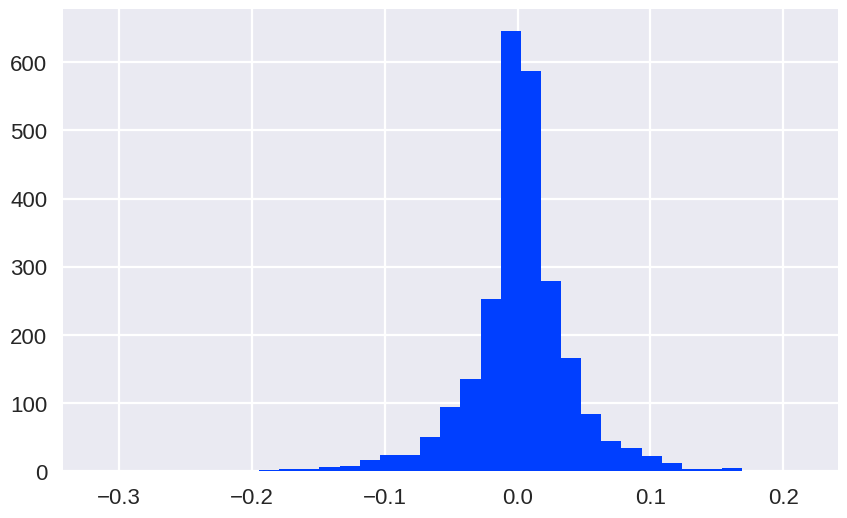

In [80]:
data['returns'].hist(bins=35, figsize=(10, 6));

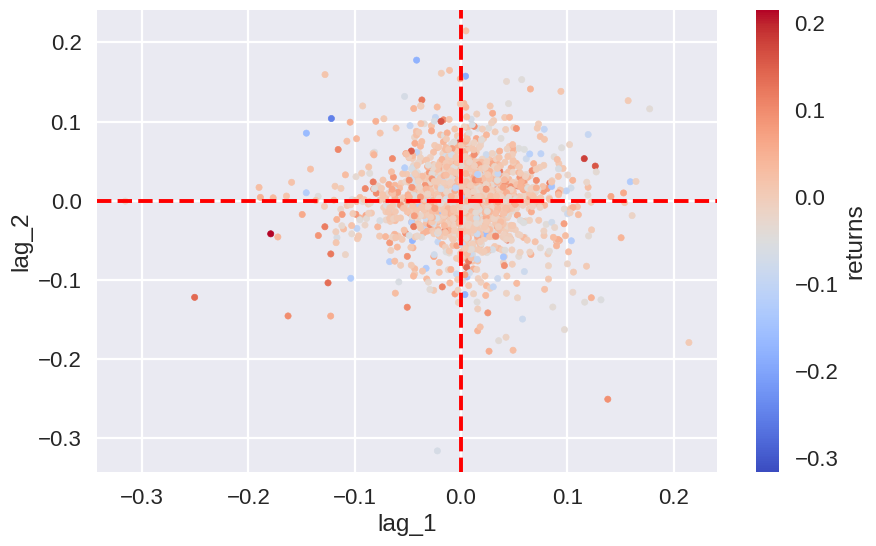

In [81]:
lags = 2

def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

create_lags(data)

data.head()

data.dropna(inplace=True)

data.plot.scatter(x='lag_1', y='lag_2', c='returns',cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');

In [82]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

data['pos_ols_1'] = model.fit(data[cols],data['returns']).predict(data[cols])

data['pos_ols_2'] = model.fit(data[cols],data['direction']).predict(data[cols])

data[['pos_ols_1', 'pos_ols_2']].head()

data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

data['pos_ols_1'].value_counts()

data['pos_ols_2'].value_counts()

(data['pos_ols_1'].diff() != 0).sum()

(data['pos_ols_2'].diff() != 0).sum()

371

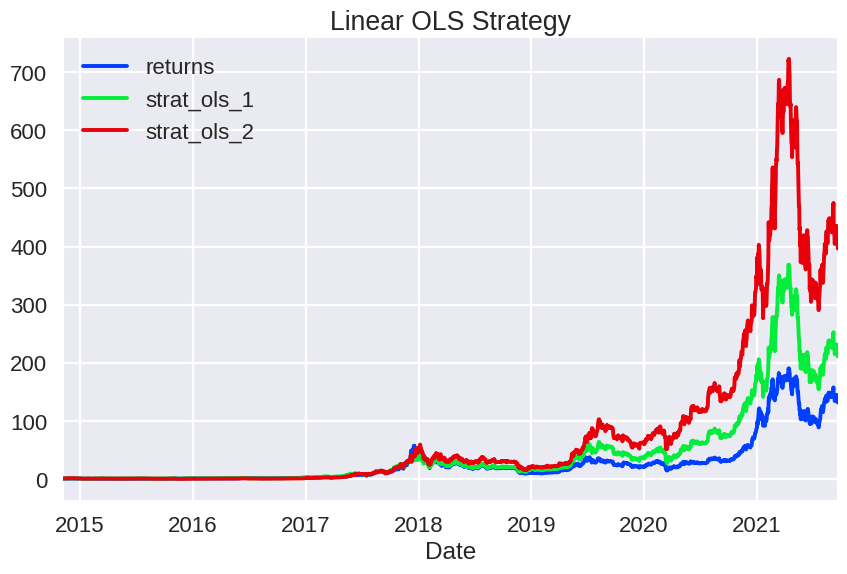

In [83]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

(data['direction'] == data['pos_ols_1']).value_counts()

(data['direction'] == data['pos_ols_2']).value_counts()

data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(10, 6))

plt.title('Linear OLS Strategy');

# 4. Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


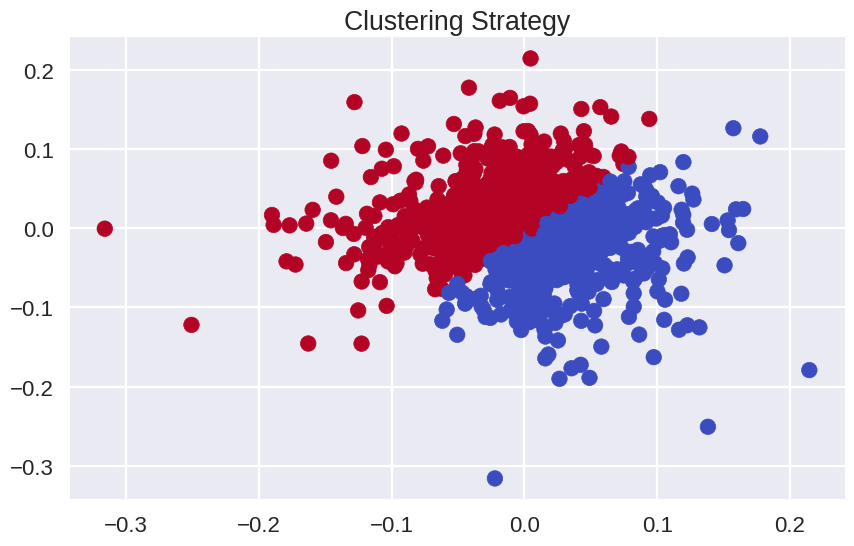

In [84]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, random_state=0)

model.fit(data[cols])

data['pos_clus'] = model.predict(data[cols])

data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)

data['pos_clus'].values

plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],c=data['pos_clus'], cmap='coolwarm')
plt.title('Clustering Strategy');

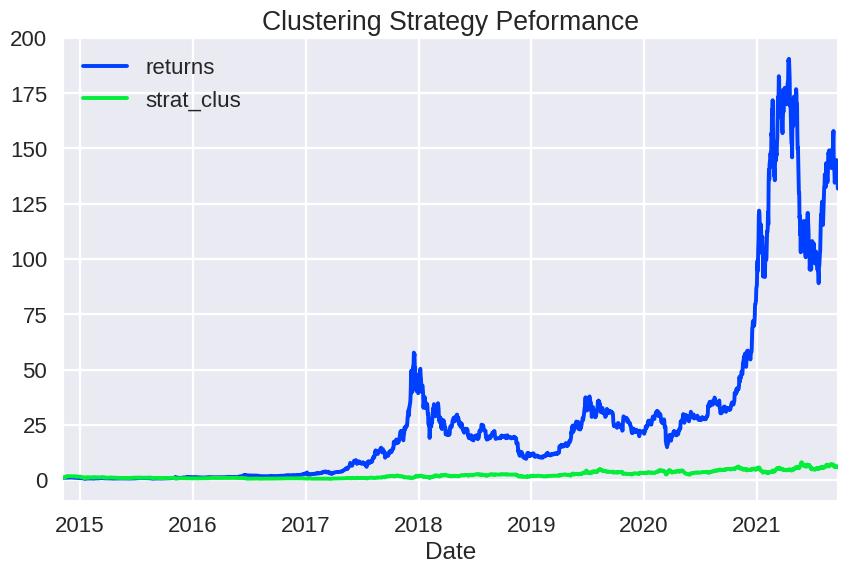

In [85]:
data['strat_clus'] = data['pos_clus'] * data['returns']

data[['returns', 'strat_clus']].sum().apply(np.exp)

(data['direction'] == data['pos_clus']).value_counts()

data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6))
plt.title('Clustering Strategy Peformance');

# 5. Frequency Approach

In [86]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)

create_bins(data)

data[cols_bin + ['direction']].head()

grouped = data.groupby(cols_bin + ['direction'])
grouped.size()

res = grouped['direction'].size().unstack(fill_value=0)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

res.style.apply(highlight_max, axis=1)

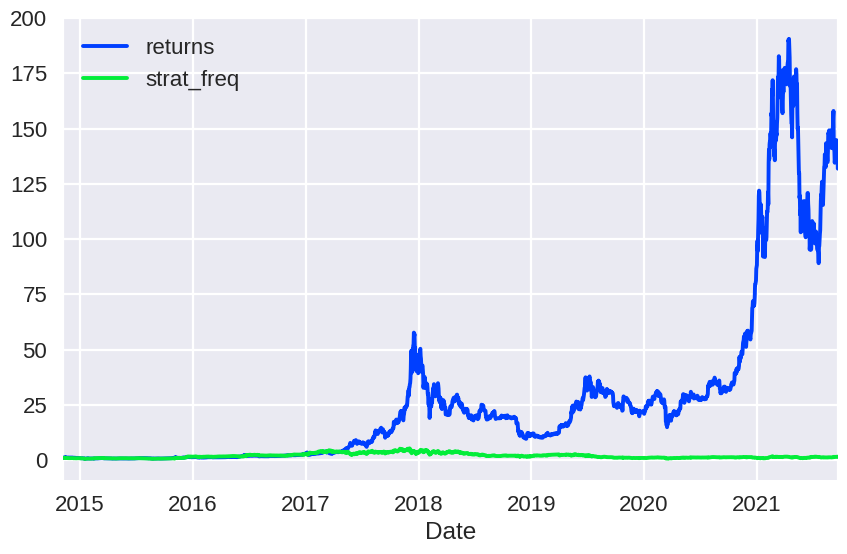

In [87]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)

(data['direction'] == data['pos_freq']).value_counts()

data['strat_freq'] = data['pos_freq'] * data['returns']

data[['returns', 'strat_freq']].sum().apply(np.exp)

data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# 6. Classification

In [88]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

C = 1

models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

def fit_models(data):
    mfit = {model: models[model].fit(data[cols_bin],data['direction'])
            for model in models.keys()}

fit_models(data)

def derive_positions(data):
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

derive_positions(data)

#### Two Binary Features

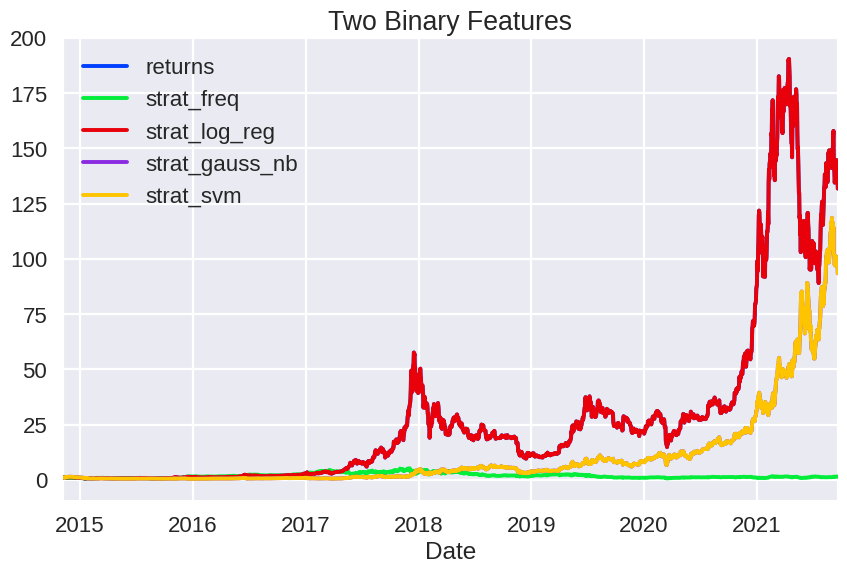

In [89]:
def evaluate_strats(data):
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

evaluate_strats(data)

sel.insert(1, 'strat_freq')

data[sel].sum().apply(np.exp)

data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6))

plt.title('Two Binary Features');

#### Five Binary Features

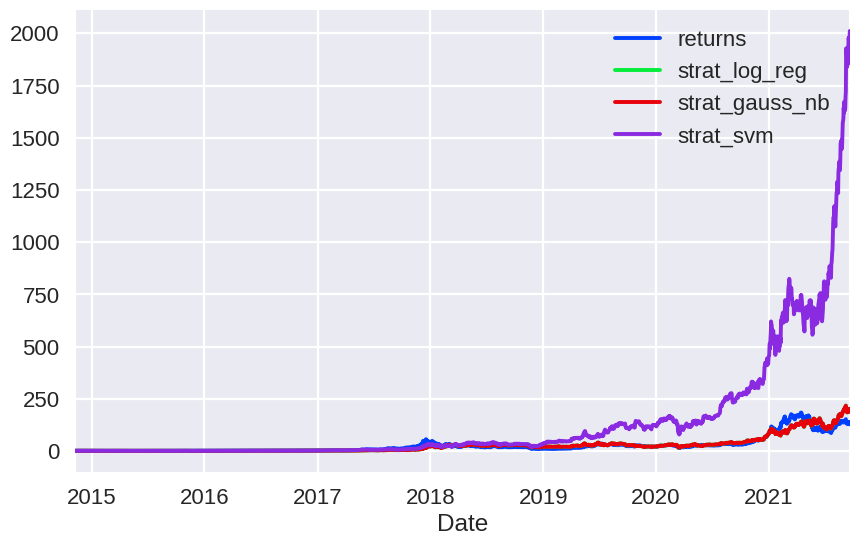

In [90]:
data = pd.DataFrame(raw[price])

data['returns'] = np.log(data / data.shift(1))

data['direction'] = np.sign(data['returns'])

lags = 5
create_lags(data)
data.dropna(inplace=True)

create_bins(data)
cols_bin

data[cols_bin].head()

data.dropna(inplace=True)

fit_models(data)

derive_positions(data)

evaluate_strats(data)

data[sel].sum().apply(np.exp)

In [80]: data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

#### Five Digitized Features

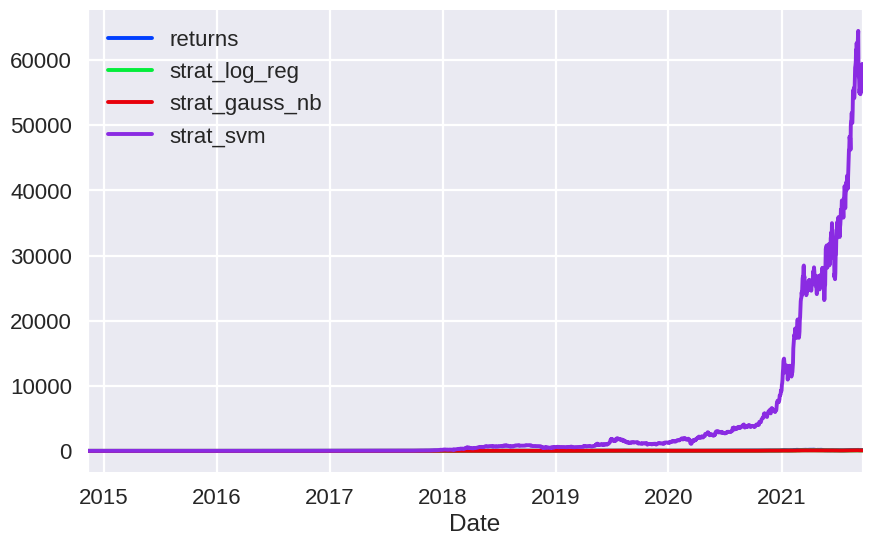

In [91]:
mu = data['returns'].mean()
v = data['returns'].std()

bins = [mu - v, mu, mu + v]
bins

create_bins(data, bins)

data[cols_bin].head()

fit_models(data)

derive_positions(data)

evaluate_strats(data)

data[sel].sum().apply(np.exp)

data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

#### Sequential Train-Test Split

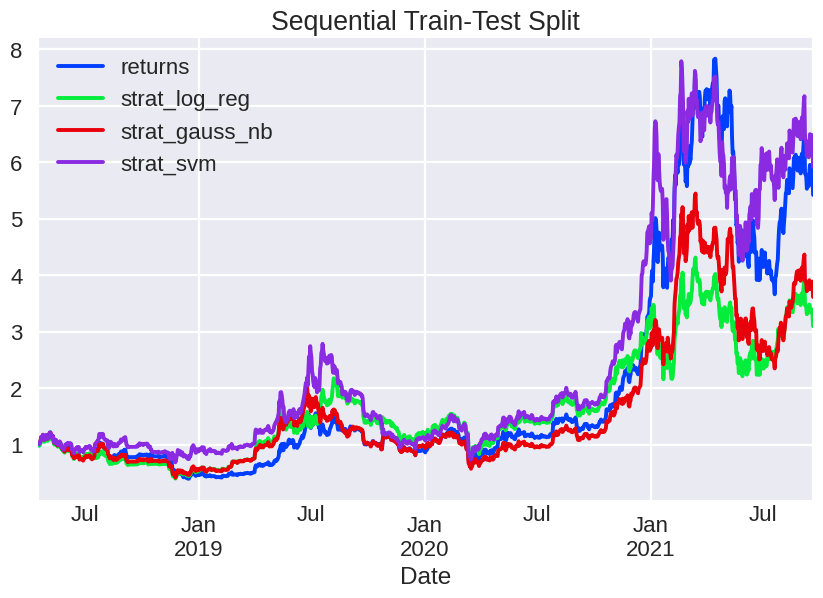

In [92]:
split = int(len(data) * 0.5)

train = data.iloc[:split].copy()

fit_models(train)

test = data.iloc[split:].copy()

derive_positions(test)

evaluate_strats(test)

test[sel].sum().apply(np.exp)

test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6))

plt.title('Sequential Train-Test Split');

#### Randomized Train-Test Split

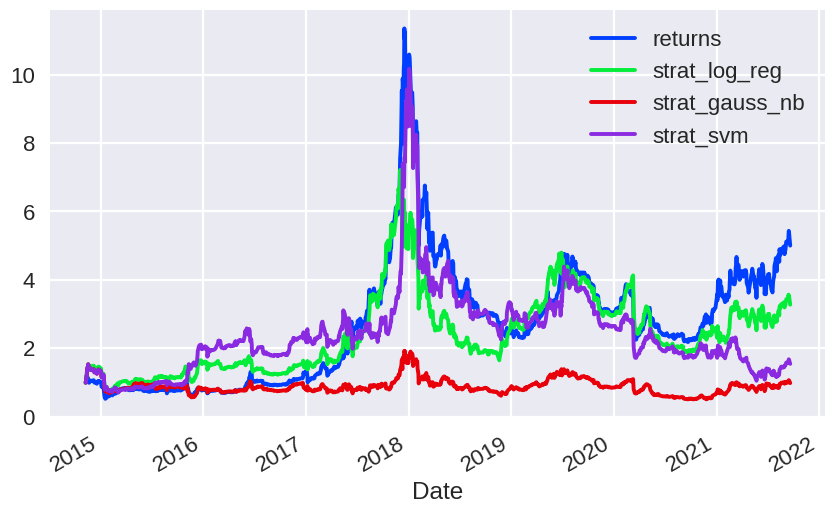

In [93]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.5,shuffle=True, random_state=100)

train = train.copy().sort_index()

train[cols_bin].head()

test = test.copy().sort_index()

fit_models(train)

derive_positions(test)

evaluate_strats(test)

test[sel].sum().apply(np.exp)

test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

# 7. Deep Neural Networks

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


CPU times: user 28.6 s, sys: 23.6 s, total: 52.3 s
Wall time: 30.3 s


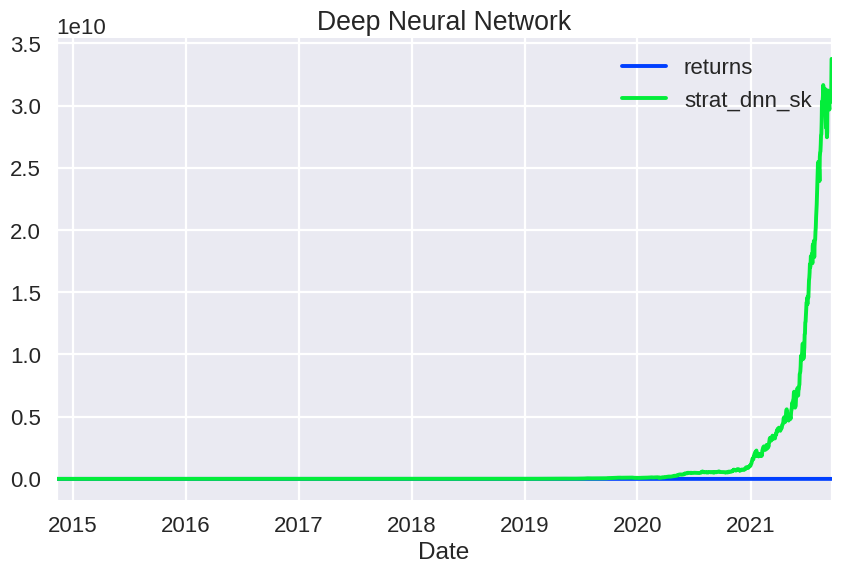

In [94]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=2 * [250],random_state=1)

%time model.fit(data[cols_bin], data['direction'])
# CPU times: user 16.1 s, sys: 156 ms, total: 16.2 s
# Wall time: 9.85 s

data['pos_dnn_sk'] = model.predict(data[cols_bin])

data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6))

plt.title('Deep Neural Network');

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


CPU times: user 3min 39s, sys: 1min 48s, total: 5min 28s
Wall time: 3min 12s


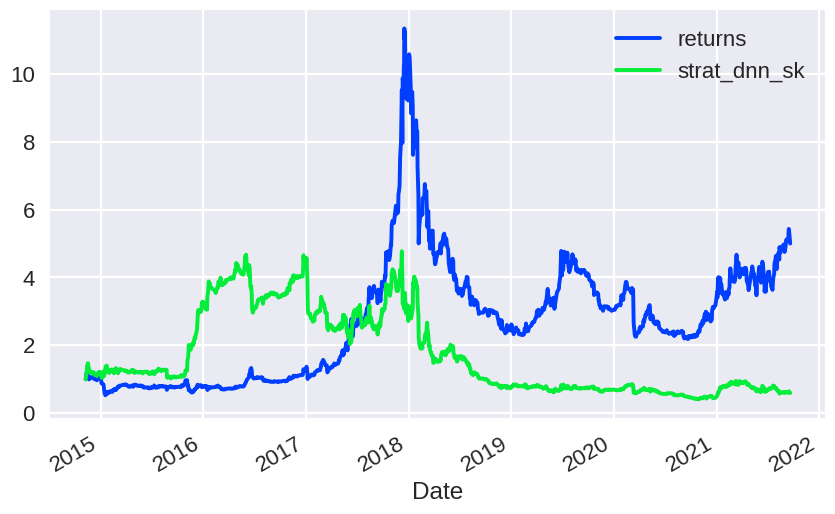

In [95]:
train, test = train_test_split(data, test_size=0.5,random_state=100)

train = train.copy().sort_index()

test = test.copy().sort_index()

model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,hidden_layer_sizes=3 * [500], random_state=1)

%time model.fit(train[cols_bin], train['direction'])
#           CPU times: user 2min 26s, sys: 1.02 s, total: 2min 27s
#           Wall time: 1min 31s

test['pos_dnn_sk'] = model.predict(test[cols_bin])

test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [96]:
# from pyspark.sql import SparkSession

# spark = SparkSession.builder.master('local[4]').appName('spark_ml').getOrCreate()

In [97]:
# Close = spark.read.options(inferSchema = True).csv('BTC_USD_Low_To_Low.csv', header=True)
# Close.show(5)